<a href="https://colab.research.google.com/github/SherlockH2003/Kelompok5-SistemCerdas/blob/main/Prediktor_Saham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PERSIAPAN

In [3]:
try :
  from google.colab import drive
  drive.mount('/content/drive')
except Exception as e :
  print("Google drive gagal ditautkan!")

Mounted at /content/drive


In [7]:
import os
import subprocess
from google.colab import files

def kaggle_upload(path):
  """
    args :
      path = direktori file kaggle.json dari Google Drive, yang akan diupload.
    return :
      None
  """

  kaggle_dir = os.path.expanduser("~/.kaggle")
  kaggle_path = os.path.join(kaggle_dir, "kaggle.json")

  try:
    # bikin file .kaggle
    os.makedirs(kaggle_dir, exist_ok=True)
    print("Folder .kaggle ditemukan, menghapus folder lama...")
  except Exception as e:
    print("Gagal membuat folder .kaggle, error log : ", e)

  try:
    # hapus file yg udah ada
    if os.path.exists(kaggle_path):
      print("File kaggle.json ditemukan, menghapus file lama...")
      os.remove(kaggle_path)

    # upload file baru
    uploaded = files.upload()
    if uploaded != {}:
      print("File berhasil diupload!")
    else:
      print("File tidak ditemukan!")

    # pindahkan file dan ubah akses file
    if 'kaggle.json' in uploaded:
      print("Memindahkan file yang diupload...")
      os.replace("kaggle.json", kaggle_path)  # pindah
      print("Mengubah akses file...")
      os.chmod(kaggle_path, 0o600)            # ubah akses ke 6-0-0
      print("Upload berhasil.")
      return
    else:
      print("Upload dibatalkan atau file salah.")

  except Exception as e:
    print("Gagal upload manual, error log :", e)

  # Ambil dari GDrive
  try:
    print("\n\nMemulai scanning file Google Drive...")
    if os.path.exists(kaggle_path):
      # menghapus file yang sama kalau sudah ada
      print("File sudah ada, menghapus file lama...")
      os.remove(kaggle_path)

    print("Menyalin file ke direktori baru...")
    os.system(f"cp {path} {kaggle_path}") # copy dan pindahin file drive ke .kaggle
    print("Mengubah akses file...")
    os.chmod(kaggle_path, 0o600)          # ubah akses ke 6-0-0
    print("Upload berhasil !")
  except Exception as e:
    print("File Kaggle.json gagal dimuat. Error Log : ", e)

path_drive = "/content/drive/MyDrive/Kaggle/kaggle.json"
kaggle_upload(path_drive)

Folder .kaggle ditemukan, menghapus folder lama...


File tidak ditemukan!
Upload dibatalkan atau file salah.


Memulai scanning file Google Drive...
Menyalin file ke direktori baru...
Mengubah akses file...
Upload berhasil !


# PREPROCESSING

In [8]:
!kaggle datasets list -s "dataset saham"

ref                                               title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
muamkh/ihsgstockdata                              Dataset Saham Indonesia / Indonesia Stock Dataset   343768044  2023-01-08 19:26:36.067000           5247         87  0.8235294        
agungpambudi/dataset-saham-bursa-efek             Dataset Saham Bursa Efek                               121660  2022-08-24 17:56:39.230000           1175         25  1.0              
kalkulasi/financial-statement-data-idx-2020-2023  Dataset Financial Statement in IDX Indonesia          1825503  2024-05-11 08:23:55.367000           3267         62  1.0              
tiwill/saham-idx                                  Pergerakan Saham di Bursa

In [9]:
!kaggle datasets download agungpambudi/dataset-saham-bursa-efek

Dataset URL: https://www.kaggle.com/datasets/agungpambudi/dataset-saham-bursa-efek
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/119k [00:00<?, ?B/s]
100% 119k/119k [00:00<00:00, 262MB/s]


In [12]:
!unzip dataset-saham-bursa-efek.zip -d dataset-saham-bursa-efek

Archive:  dataset-saham-bursa-efek.zip
  inflating: dataset-saham-bursa-efek/Data Tambahan/TLKM.csv  
  inflating: dataset-saham-bursa-efek/Saham Perusahaan/TLKM.csv  


In [156]:
try :
  import pandas as pd
  import matplotlib.pyplot as plt
  import numpy as np
  import tensorflow as tf
  print("versi tensorflow saat ini :",tf.__version__)
except Exception as e :
  print("Gagal mengimport library, error log : ", e)

# Extract Data
path_saham = "/content/dataset-saham-bursa-efek/Saham Perusahaan/TLKM.csv"
pd.set_option('display.max_columns', None)

df = pd.read_csv(path_saham)
df

versi tensorflow saat ini : 2.18.0


,date,previous,open_price,first_trade,high,low,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2015-01-02T00:00:00,2865.0,2885.0,2885.0,2885.0,2850.0,2860.0,-5.0,18992100.0,5.446061e+10,1913.0,1503.0,2860.0,3676300.0,2855.0,465400.0,1.008000e+11,1.008000e+11,1.008000e+11,12444700.0,14812400.0,NaN,3842037.0,1.099951e+10,16.0
1,2015-01-05T00:00:00,2860.0,2850.0,2845.0,2850.0,2820.0,2835.0,-25.0,49940700.0,1.415613e+11,2831.0,1489.9,2835.0,1016300.0,2830.0,141100.0,1.008000e+11,1.008000e+11,1.008000e+11,40159200.0,14416700.0,NaN,51005200.0,1.443427e+11,15.0
2,2015-01-06T00:00:00,2835.0,2810.0,2805.0,2835.0,2800.0,2815.0,-20.0,47892100.0,1.352926e+11,3836.0,1479.4,2825.0,1002500.0,2815.0,3965500.0,1.008000e+11,1.008000e+11,1.008000e+11,39185100.0,22235000.0,NaN,5528879.0,1.563818e+10,19.0
3,2015-01-07T00:00:00,2815.0,2865.0,2865.0,2870.0,2795.0,2810.0,-5.0,70076600.0,1.972963e+11,5403.0,1476.7,2815.0,6323800.0,2810.0,1444500.0,1.008000e+11,1.008000e+11,1.008000e+11,28073400.0,26988900.0,NaN,6856526.0,1.929003e+10,25.0
4,2015-01-08T00:00:00,2810.0,2840.0,2830.0,2845.0,2825.0,2835.0,25.0,56582500.0,1.601808e+11,4082.0,1489.9,2835.0,2138900.0,2830.0,800.0,1.008000e+11,1.008000e+11,1.008000e+11,42113800.0,33079600.0,NaN,41963766.0,1.184935e+11,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,2022-03-29T00:00:00,4600.0,4600.0,4610.0,4620.0,4560.0,4560.0,-40.0,77920800.0,3.570483e+11,9463.0,2396.4,4570.0,2001300.0,4560.0,466500.0,9.906222e+10,9.906222e+10,6.806565e+10,29300900.0,61974600.0,NaN,16889279.0,7.704843e+10,16.0
1762,2022-03-30T00:00:00,4560.0,4620.0,4620.0,4620.0,4560.0,4580.0,20.0,118749100.0,5.441447e+11,6638.0,2406.9,4590.0,3089100.0,4580.0,6693900.0,9.906222e+10,9.906222e+10,6.806565e+10,31938500.0,97096600.0,NaN,41615194.0,1.908259e+11,21.0
1763,2022-03-31T00:00:00,4580.0,4620.0,4620.0,4640.0,4560.0,4580.0,0.0,108109700.0,4.960443e+11,7505.0,2406.9,4590.0,3277000.0,4580.0,60800.0,9.906222e+10,9.906222e+10,6.806565e+10,47374300.0,99963600.0,NaN,12544684.0,5.755575e+10,15.0
1764,2022-04-01T00:00:00,4580.0,4550.0,4580.0,4580.0,4530.0,4580.0,0.0,86590300.0,3.948507e+11,9760.0,2406.9,4580.0,8373500.0,4570.0,538900.0,9.906222e+10,9.906222e+10,4.740127e+10,37861400.0,70074000.0,NaN,60927236.0,2.801504e+11,14.0


## Data Transformation

In [157]:
df['date'] = pd.to_datetime(df['date'])  # Ubah string pada kolom date menjadi tipe data DateTime
df_bulanan = df.resample('ME', on='date').mean(numeric_only=True)

# Kolom 1 : Tanggal
time_saham     = df['date']  # Ubah tipe data DateTime ke string (harian)
time_bulanan   = df_bulanan.index                               # Ubah tipe data DateTime ke string (bulanan)

# Kolom 2 : Harga
series_saham   = np.array(df['close'])  # Harga saham TLKM penutupan sesi 2 (harian)
series_bulanan = df_bulanan['close']    # Harga rata-rata penutupan saham TLKM bulanan

# series_bulanan = (df_bulanan['open_price'] + df_bulanan['close']) / 2 # Harga rata-rata "rata-rata pembukaan dan rata-rata penutupan bulanan"

df_baru = pd.DataFrame({'close' : series_bulanan})
df_baru

,close
date,
2015-01-31,2848.333333
2015-02-28,2885.526316
2015-03-31,2920.681818
2015-04-30,2812.380952
2015-05-31,2828.421053
...,...
2021-12-31,4108.636364
2022-01-31,4204.285714
2022-02-28,4329.444444


In [158]:
def plot_series(time, series, title=None, format="-", start=0, end=None):
  plt.figure(figsize=(30, 10))
  plt.plot(time, series)
  plt.xlabel("Tanggal")
  plt.ylabel("Harga")
  plt.title(title)
  plt.grid(True)
  plt.show()

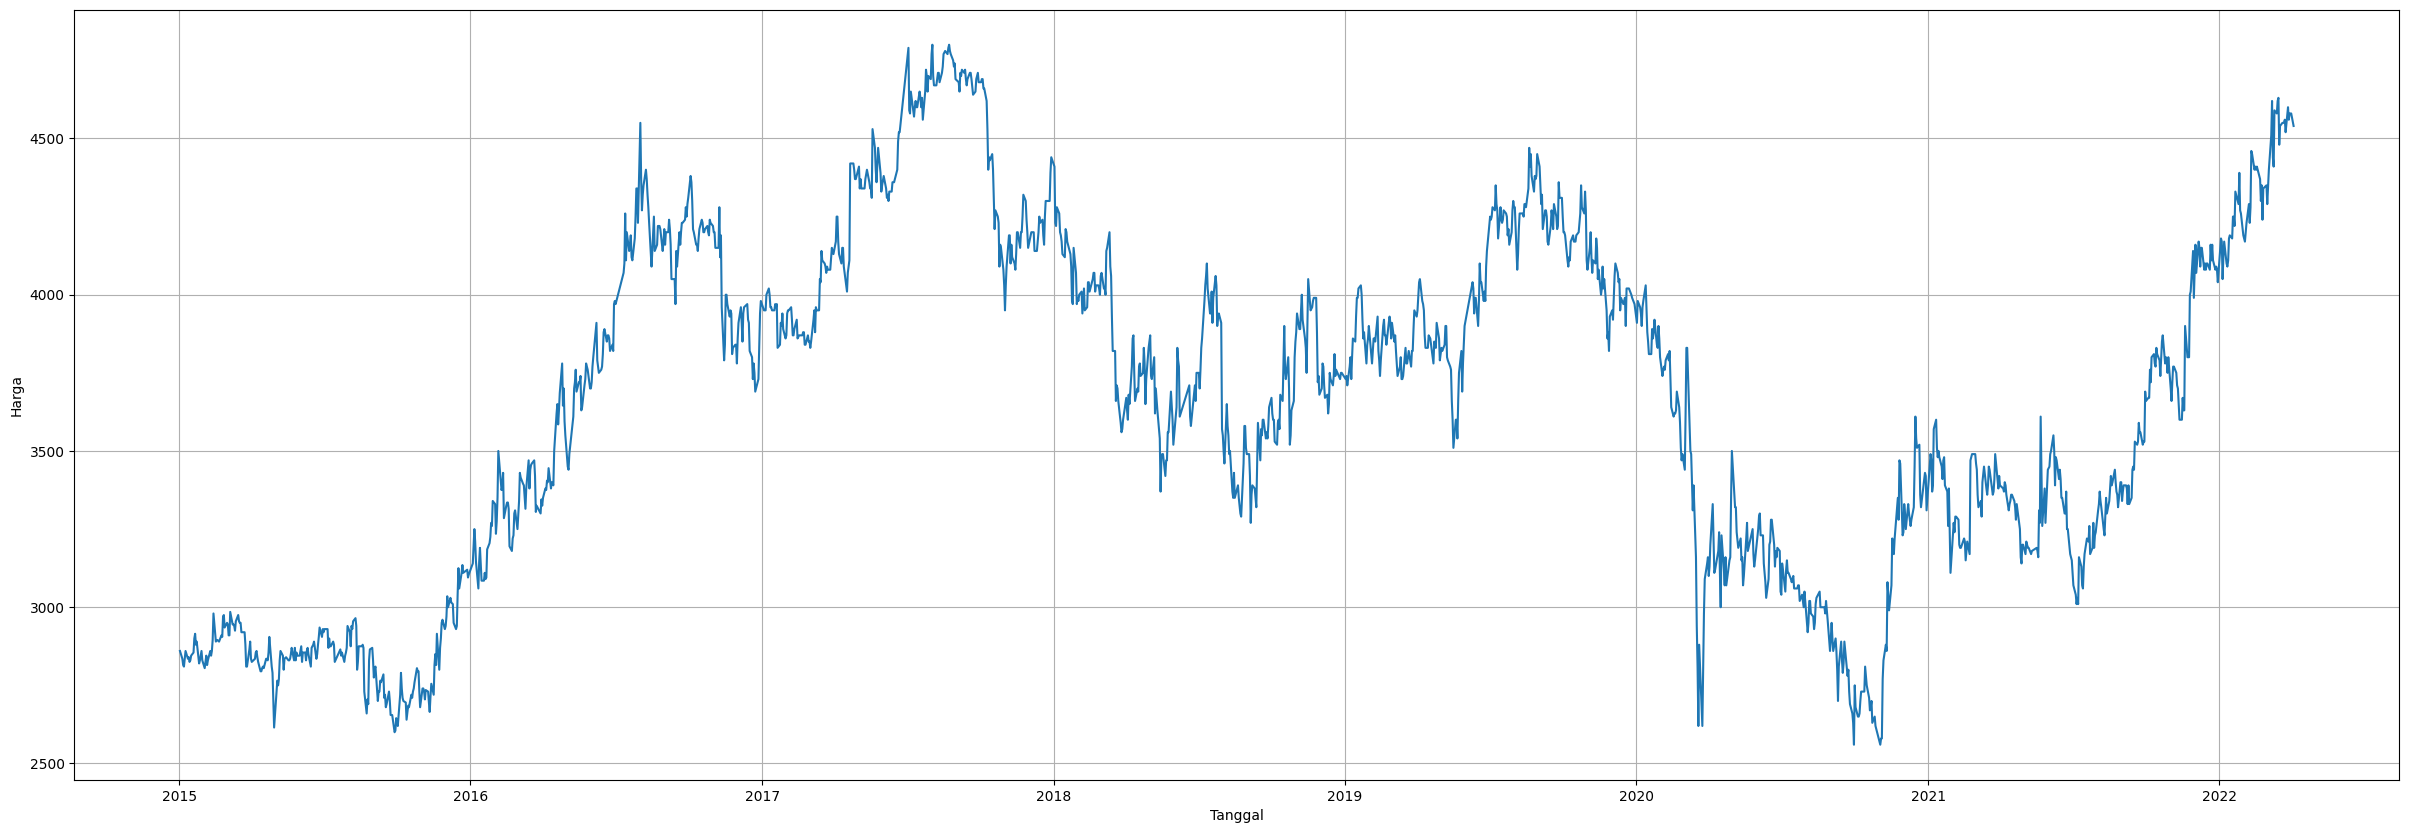

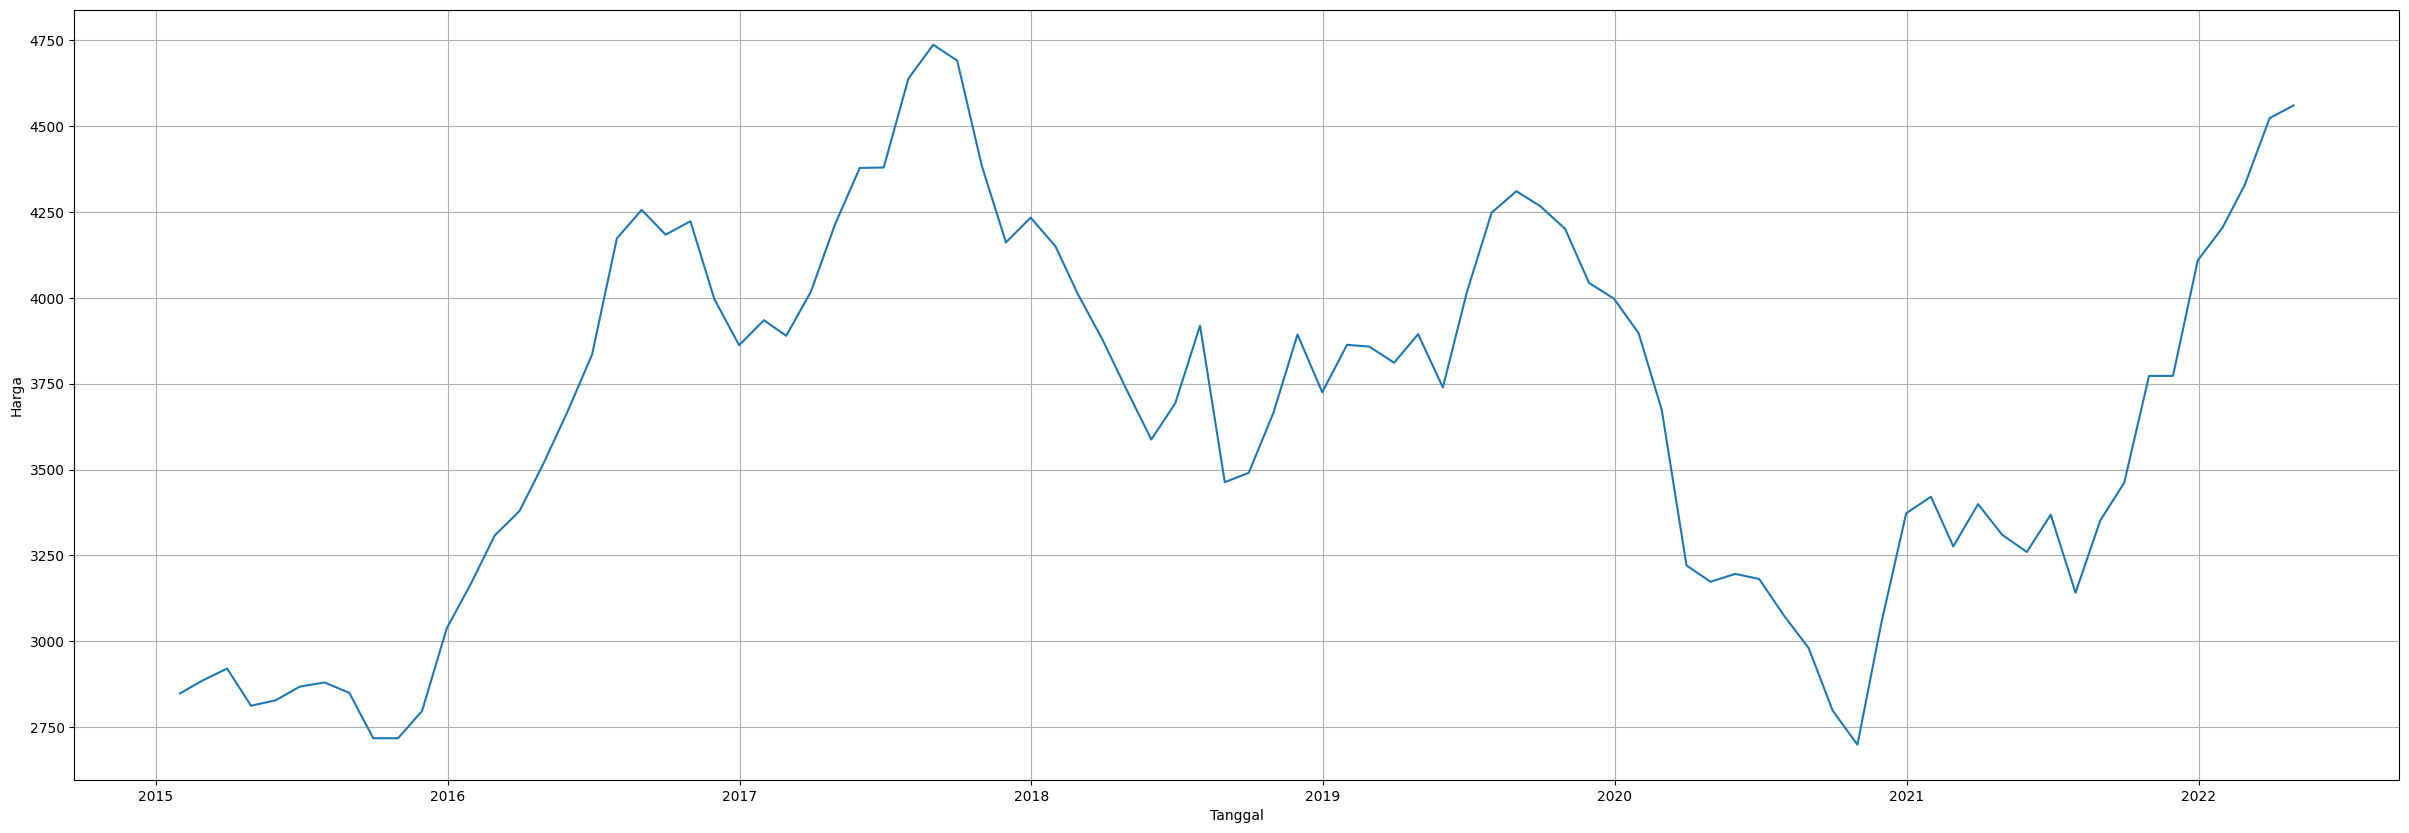

In [159]:
import matplotlib.dates as mdates

plot_series(time_saham, series_saham)
plot_series(time_bulanan, series_bulanan)

## Data Splitting

1766


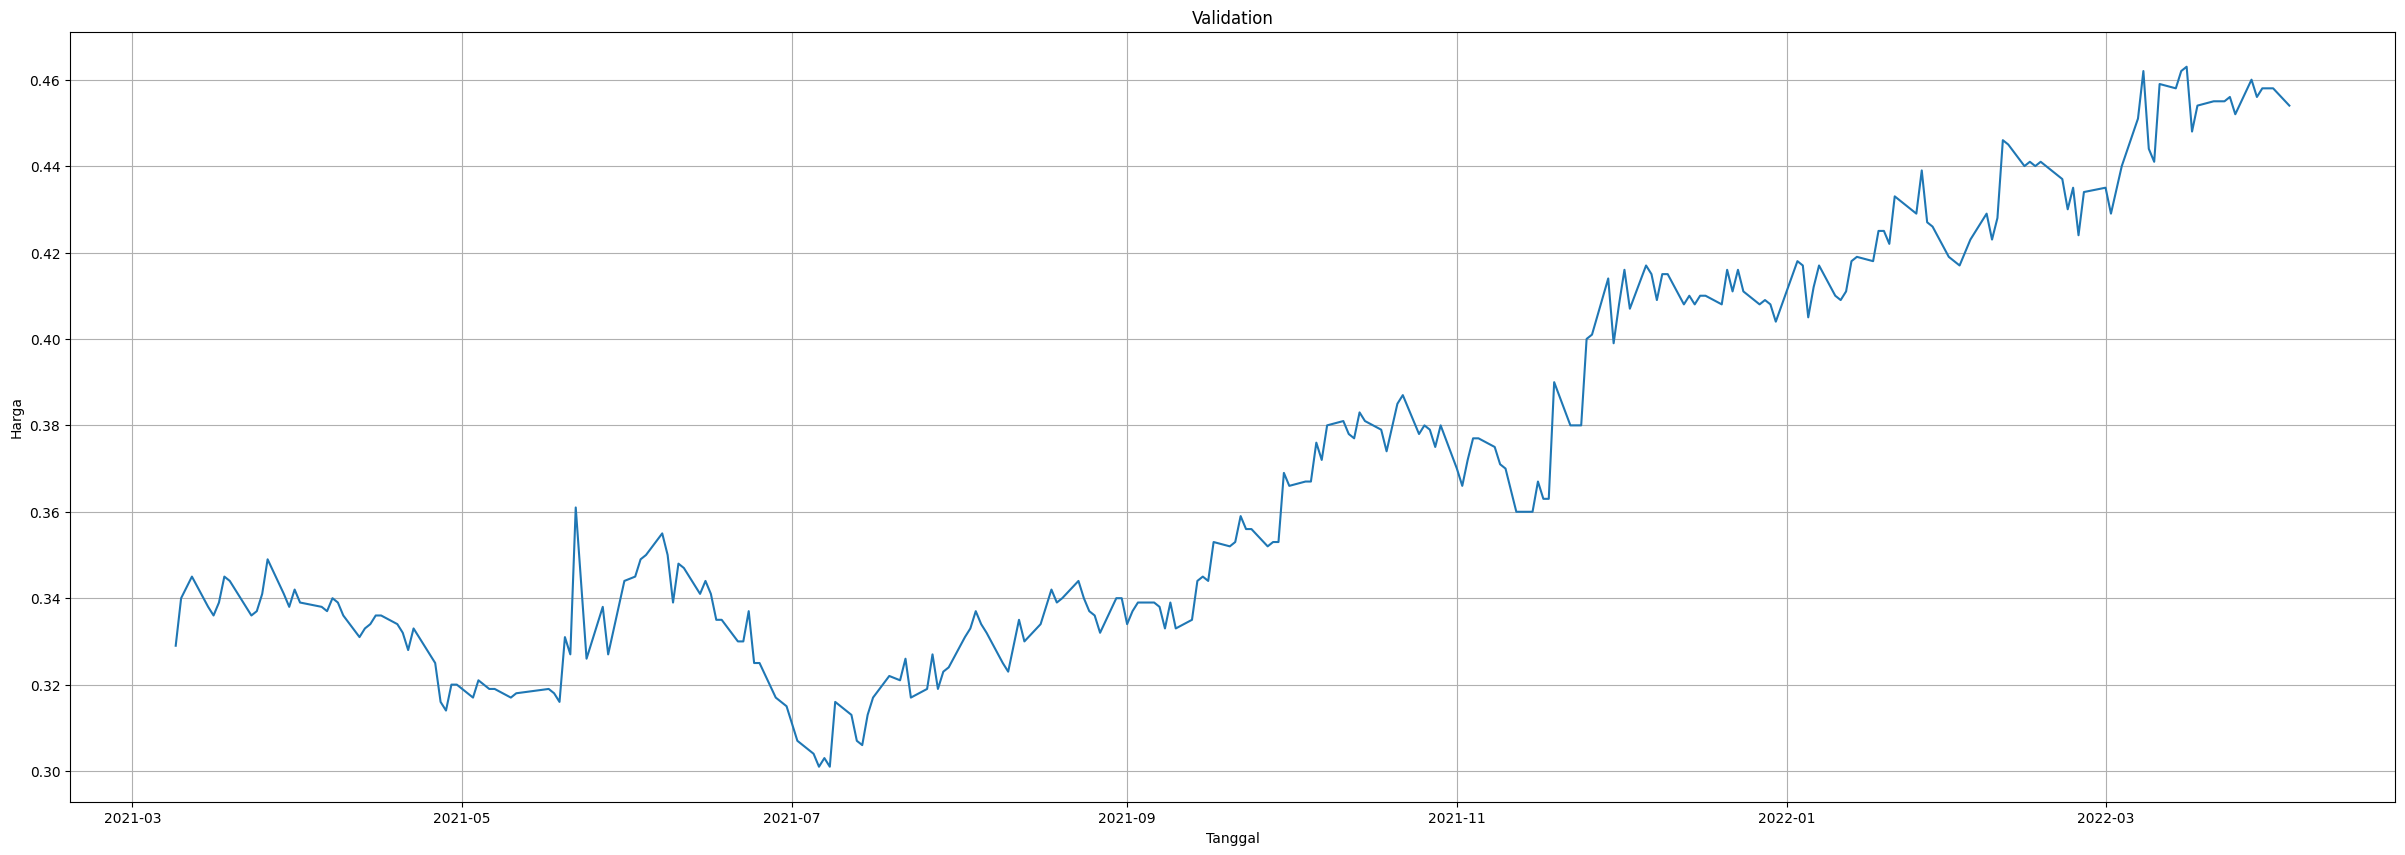

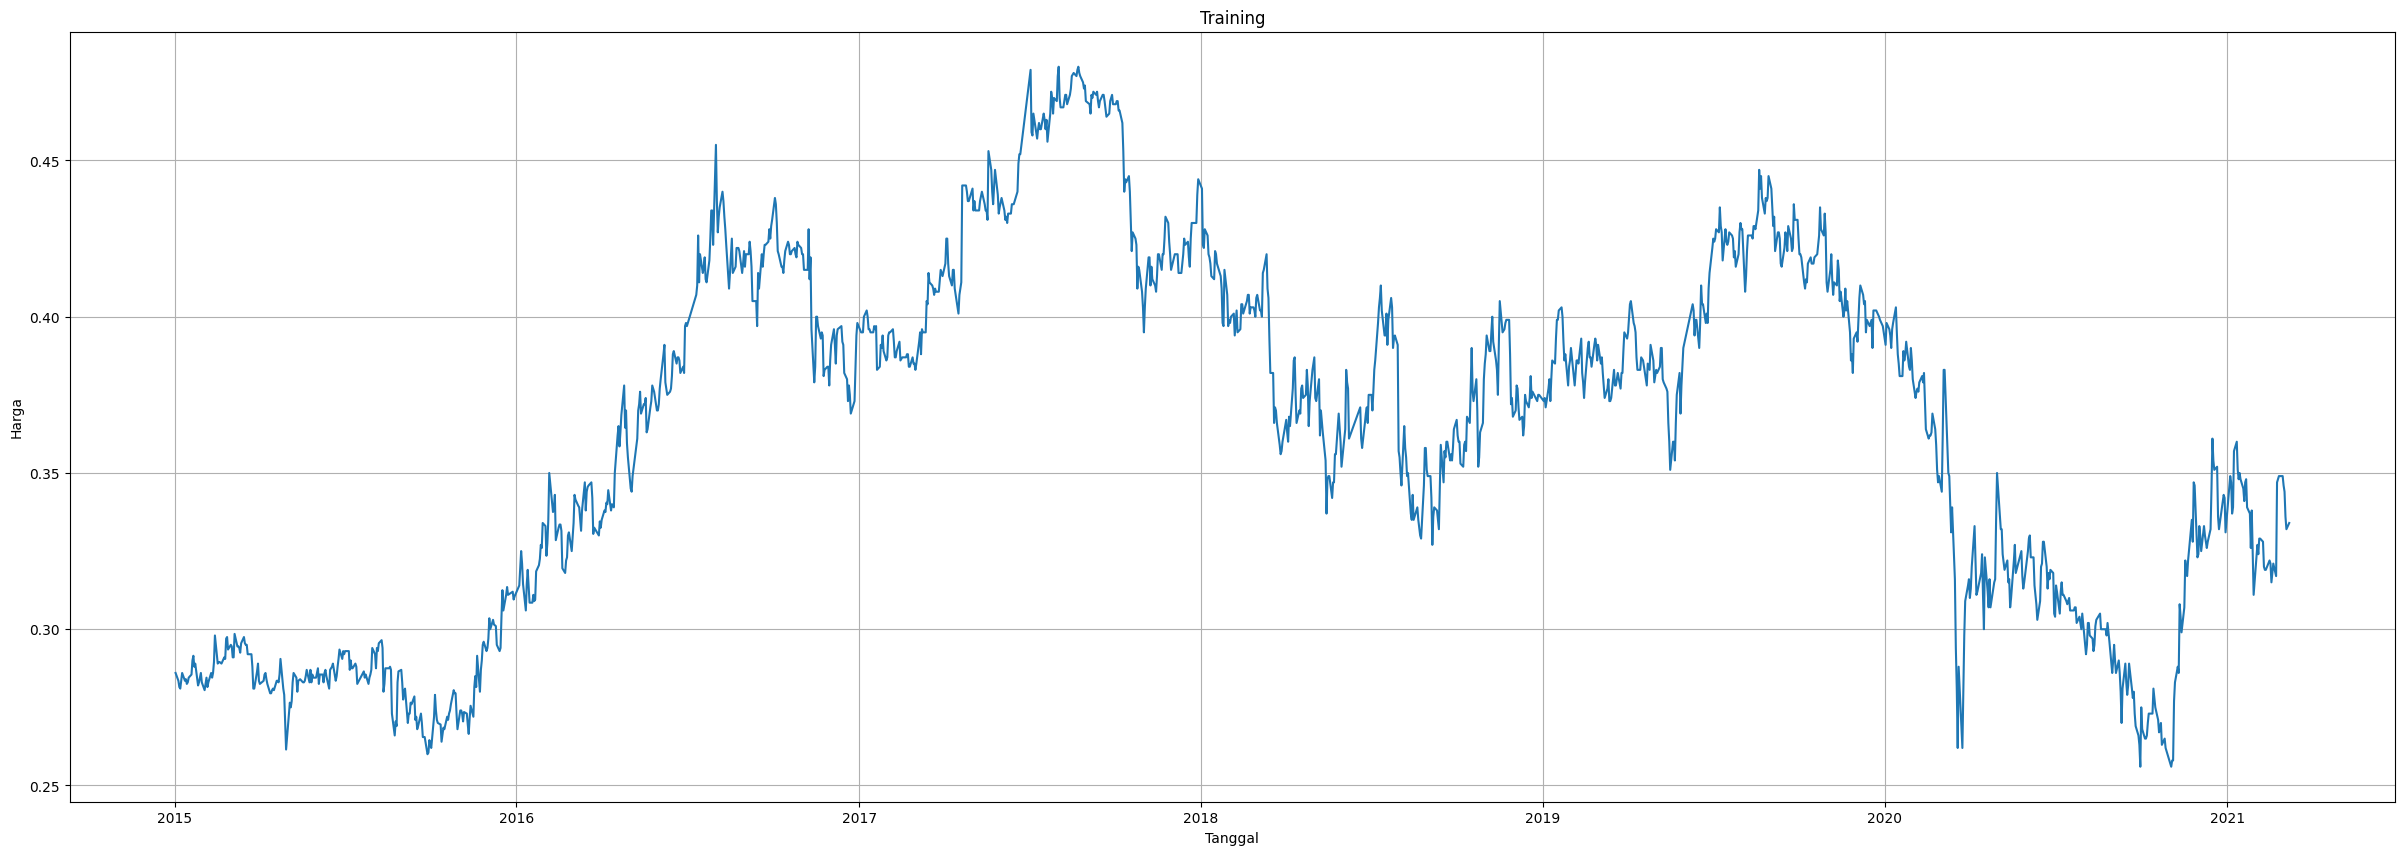

In [160]:
print(len(time_saham))

# Menentukan berapa banyak yang dipotong
# persen     = 90
# split_time = int(90/100*len(time_saham))
split_time = 1500

# Training + Normalisasi
timeSaham_train   = time_saham[:split_time]
seriesSaham_train = series_saham[:split_time]/10000

# Validation dataset
timeSaham_valid   = time_saham[split_time:]
seriesSaham_valid = series_saham[split_time:]/10000
plot_series(timeSaham_valid, seriesSaham_valid, title="Validation")


plot_series(timeSaham_train, seriesSaham_train, title="Training")


In [161]:
# Parameters
WINDOW_SIZE         = 20    # cuplikan/jendela sebesar 20 hari
BATCH_SIZE          = 32
SHUFFLE_BUFFER_SIZE = 1766

def windowed_dataset_saham(series, window_size, batch_size, shuffle_buffer):
    """
    Membuat cuplikan/jendela dataset dari data time series.

    Args:
      series (array of float) - nilai (series) dari data time-series
      window_size (int)       - ukuran cuplikan
      batch_size (int)        - ukuran batch
      shuffle_buffer(int)     - buffer size untuk shuffling

    Returns:
      dataset (TF Dataset)    - Dataset yang siap untuk training
    """

    # Ubah data ke objek tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Mengambil cuplikan, dan mengatur pergeseran cuplikan
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Meratakan cuplikan ke dalam satu batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Membuat array dari cuplikan dan satu nilai setelahnya
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle cuplikan
    dataset = dataset.shuffle(shuffle_buffer)

    # Batch cuplikan
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

# Buat dataset saham dari tipe data objek "TensorFlow Dataset"
dataset_saham = windowed_dataset_saham(seriesSaham_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

# MODELLING

In [162]:
# Bangun modelnya

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(WINDOW_SIZE,)),
    # tf.keras.layers.Dense(32, activation="relu"),
    # tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

In [163]:
# Atur evaluasi
model.compile(loss      = "mae",
              optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics   = ["mse"])

# Jalankan pelatihan!
model.fit(dataset_saham, epochs=100)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - mse: 4.4906e-04
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - mse: 3.9824e-04
Epoch 3/100
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - mse: 3.5342e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - mse: 3.4854e-04
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - mse: 3.0470e-04
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - mse: 2.6662e-04
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mse: 2.3426e-04
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - mse: 2.0711e-04
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0108 - mse: 1.8481e-04
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - mse: 1.6679e-04
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - mse: 1.5279e-04
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - mse: 1.4180e-04
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087 - mse: 1.3331e-04
Epoch 13/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mse: 1.2690e-04
Epoch 14/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mse: 1.2228e-04

# FORECASTING

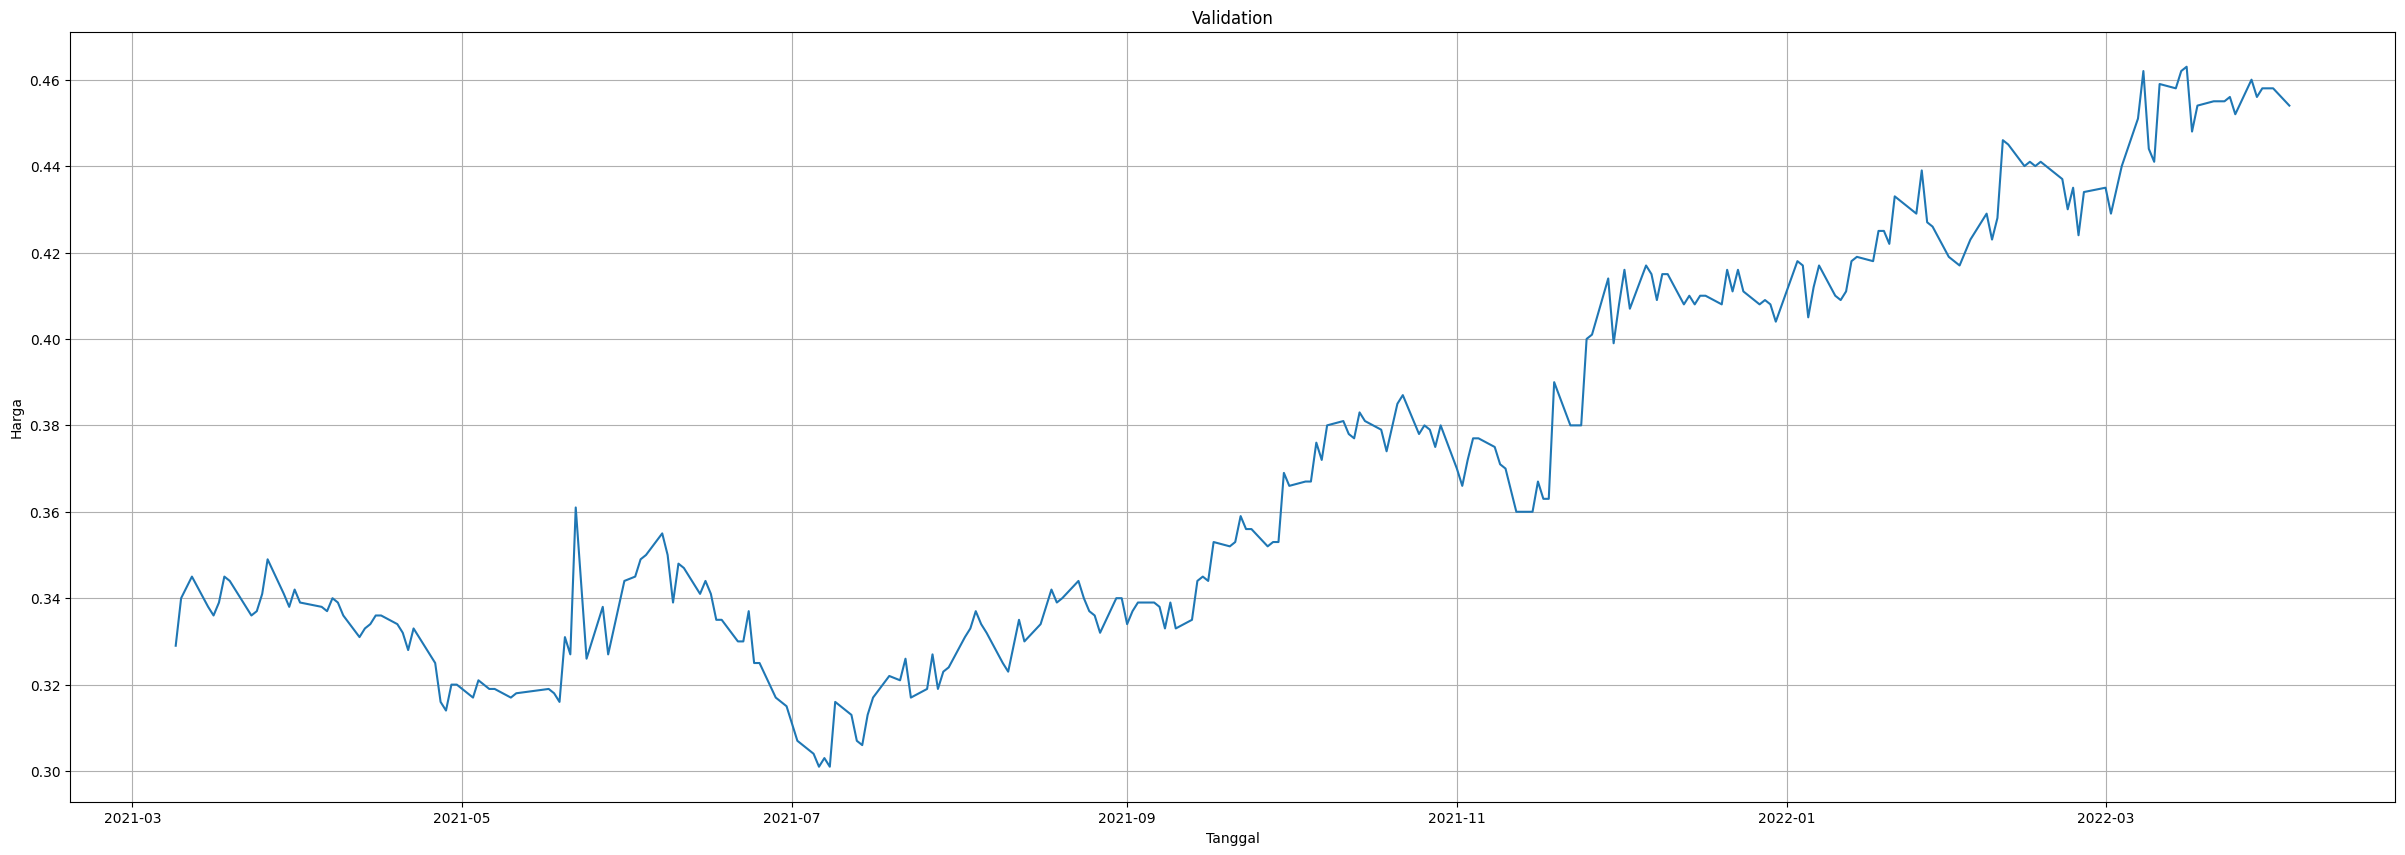

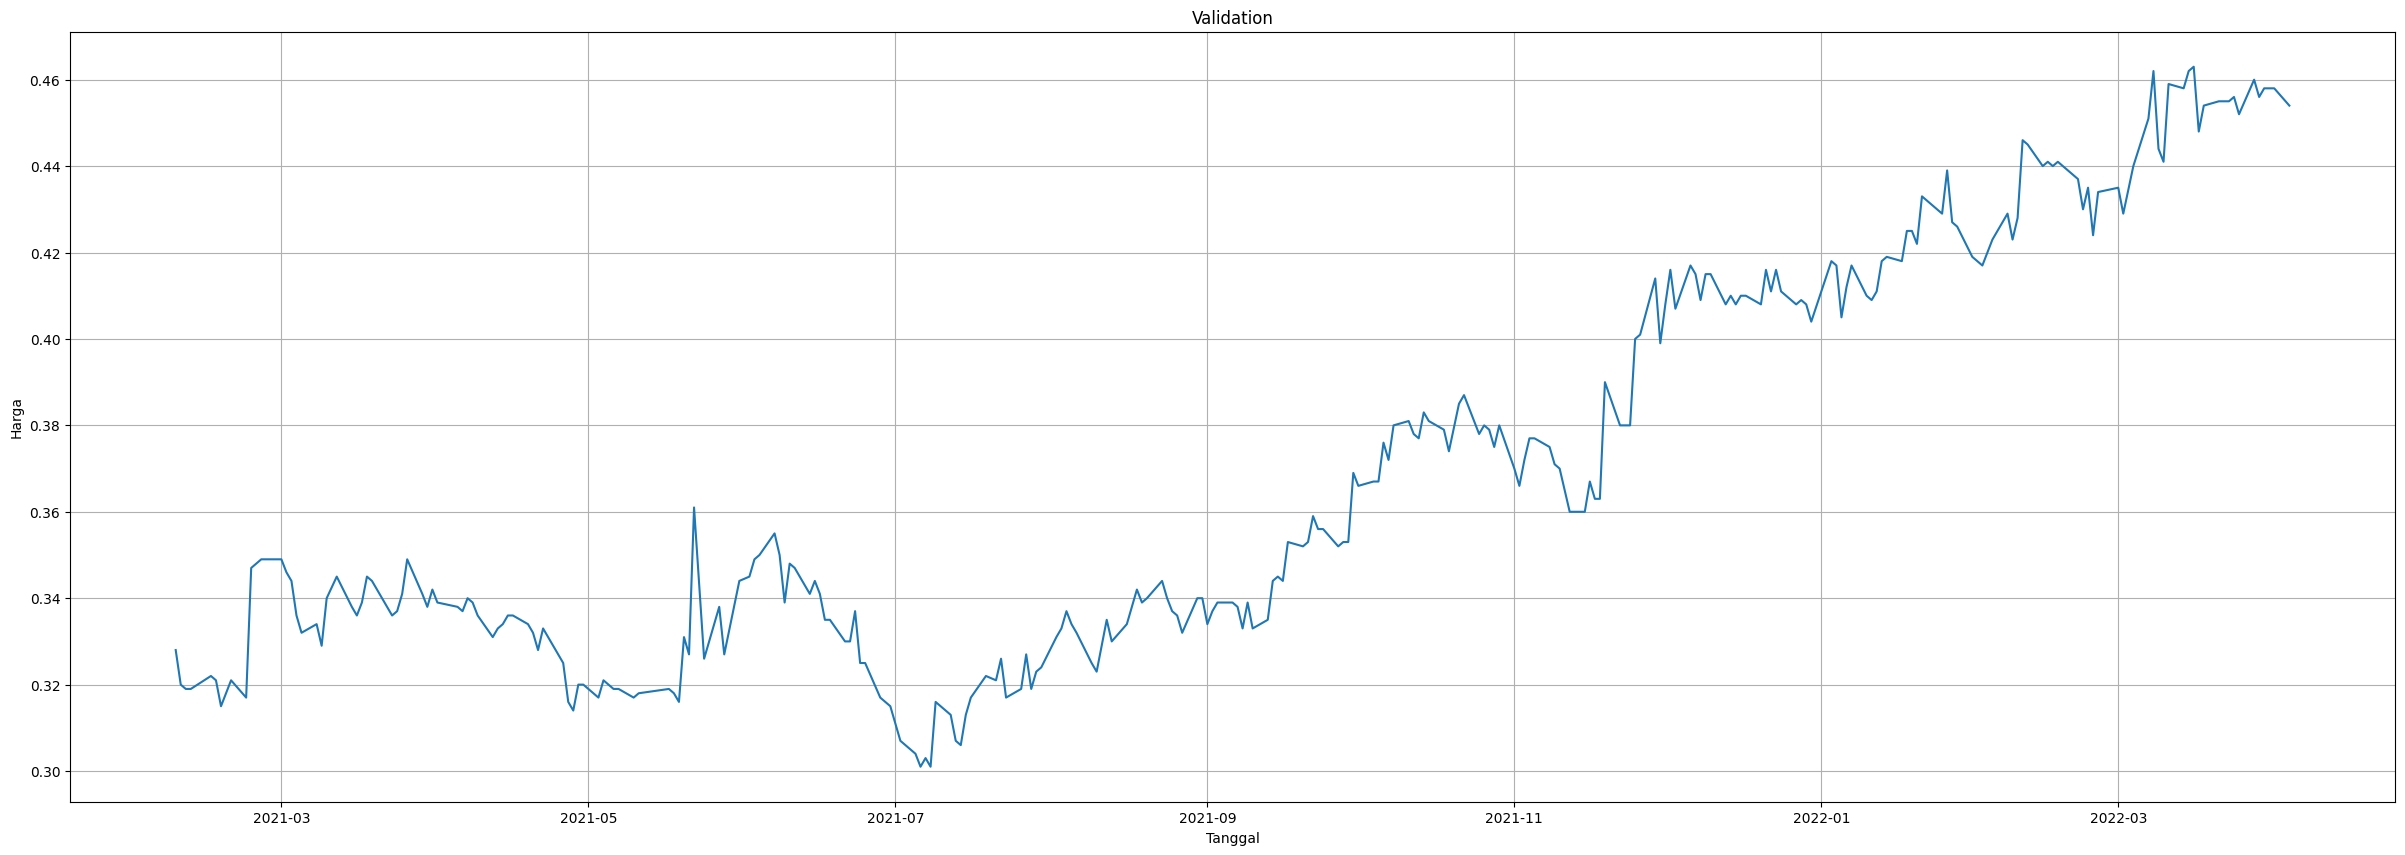

In [164]:
# Validation dataset
timeSaham_valid   = time_saham[split_time:]
seriesSaham_valid = series_saham[split_time:]/10000
plot_series(timeSaham_valid, seriesSaham_valid, title="Validation")

# Validation dataset (windowed)
WindowedTimeSaham_valid   = time_saham[split_time-WINDOW_SIZE:]
WindowedSeriesSaham_valid = series_saham[split_time-WINDOW_SIZE:]/10000
plot_series(WindowedTimeSaham_valid, WindowedSeriesSaham_valid, title="Validation")

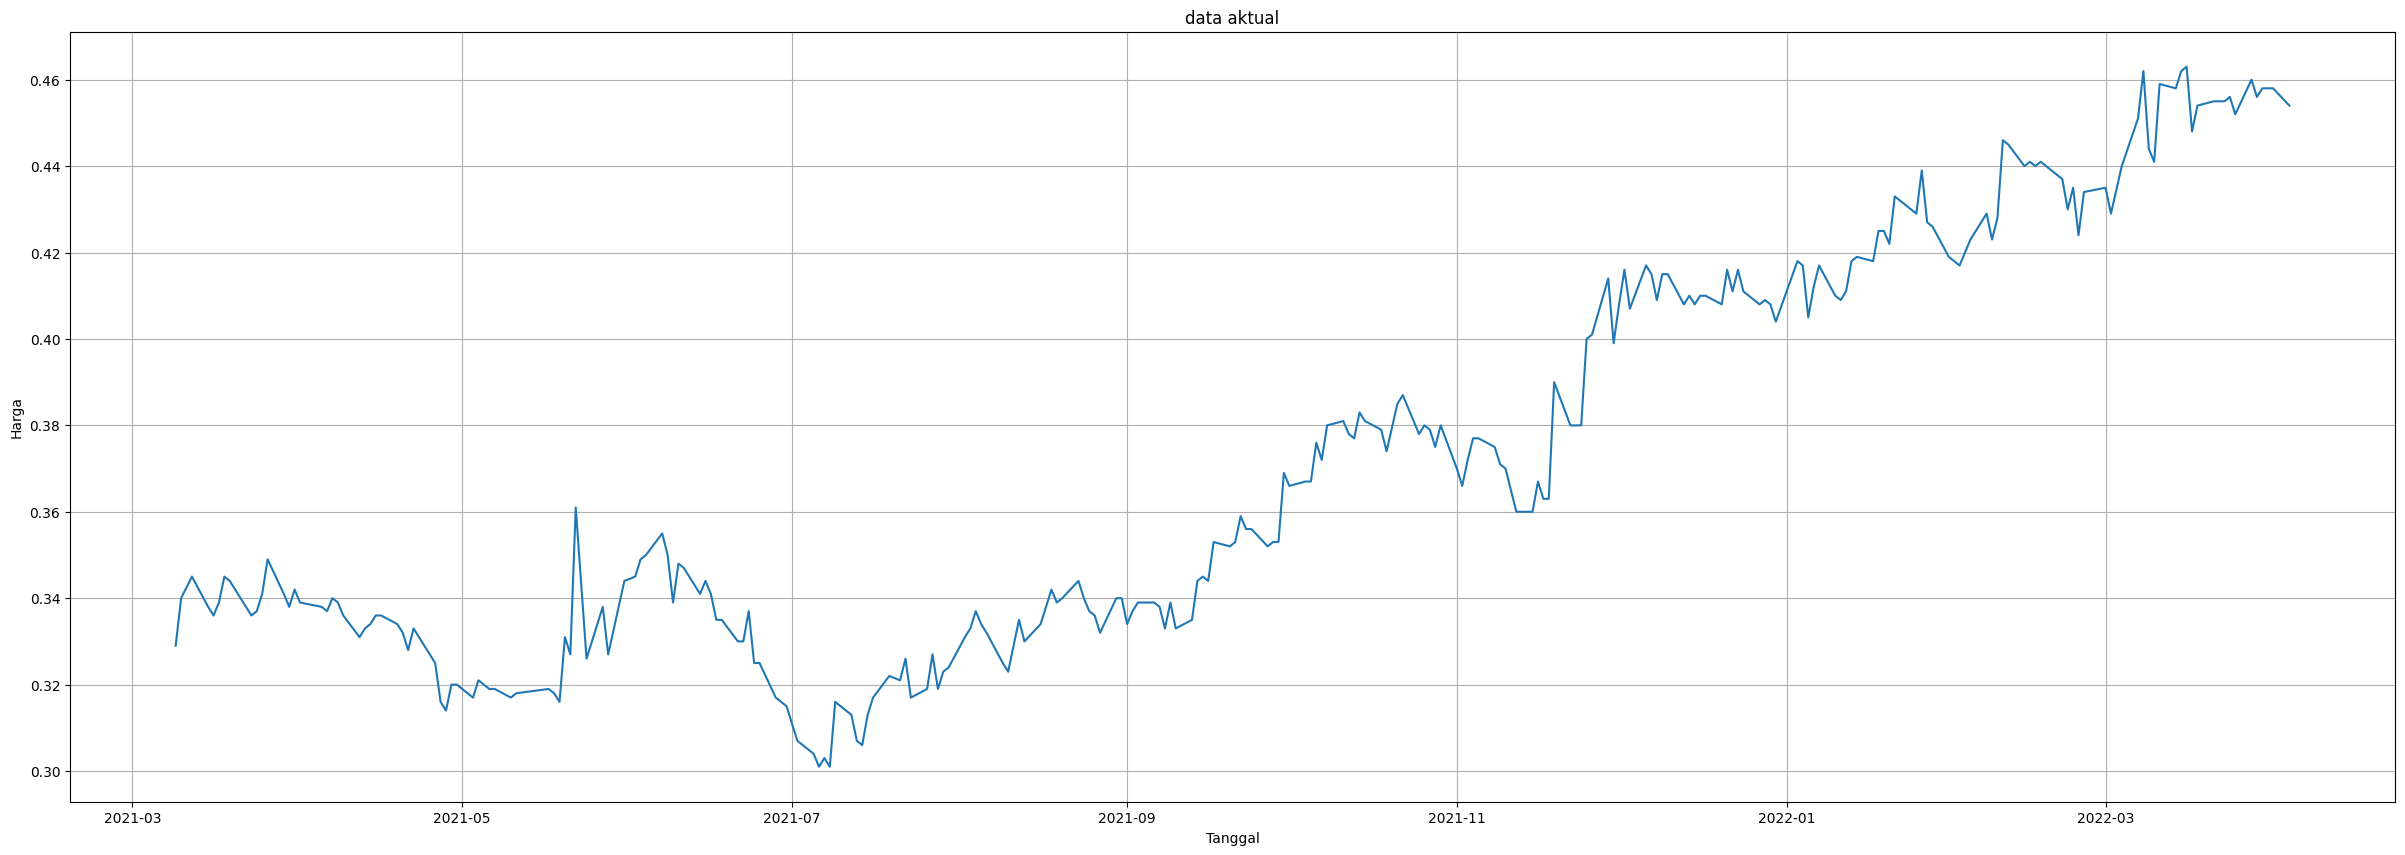

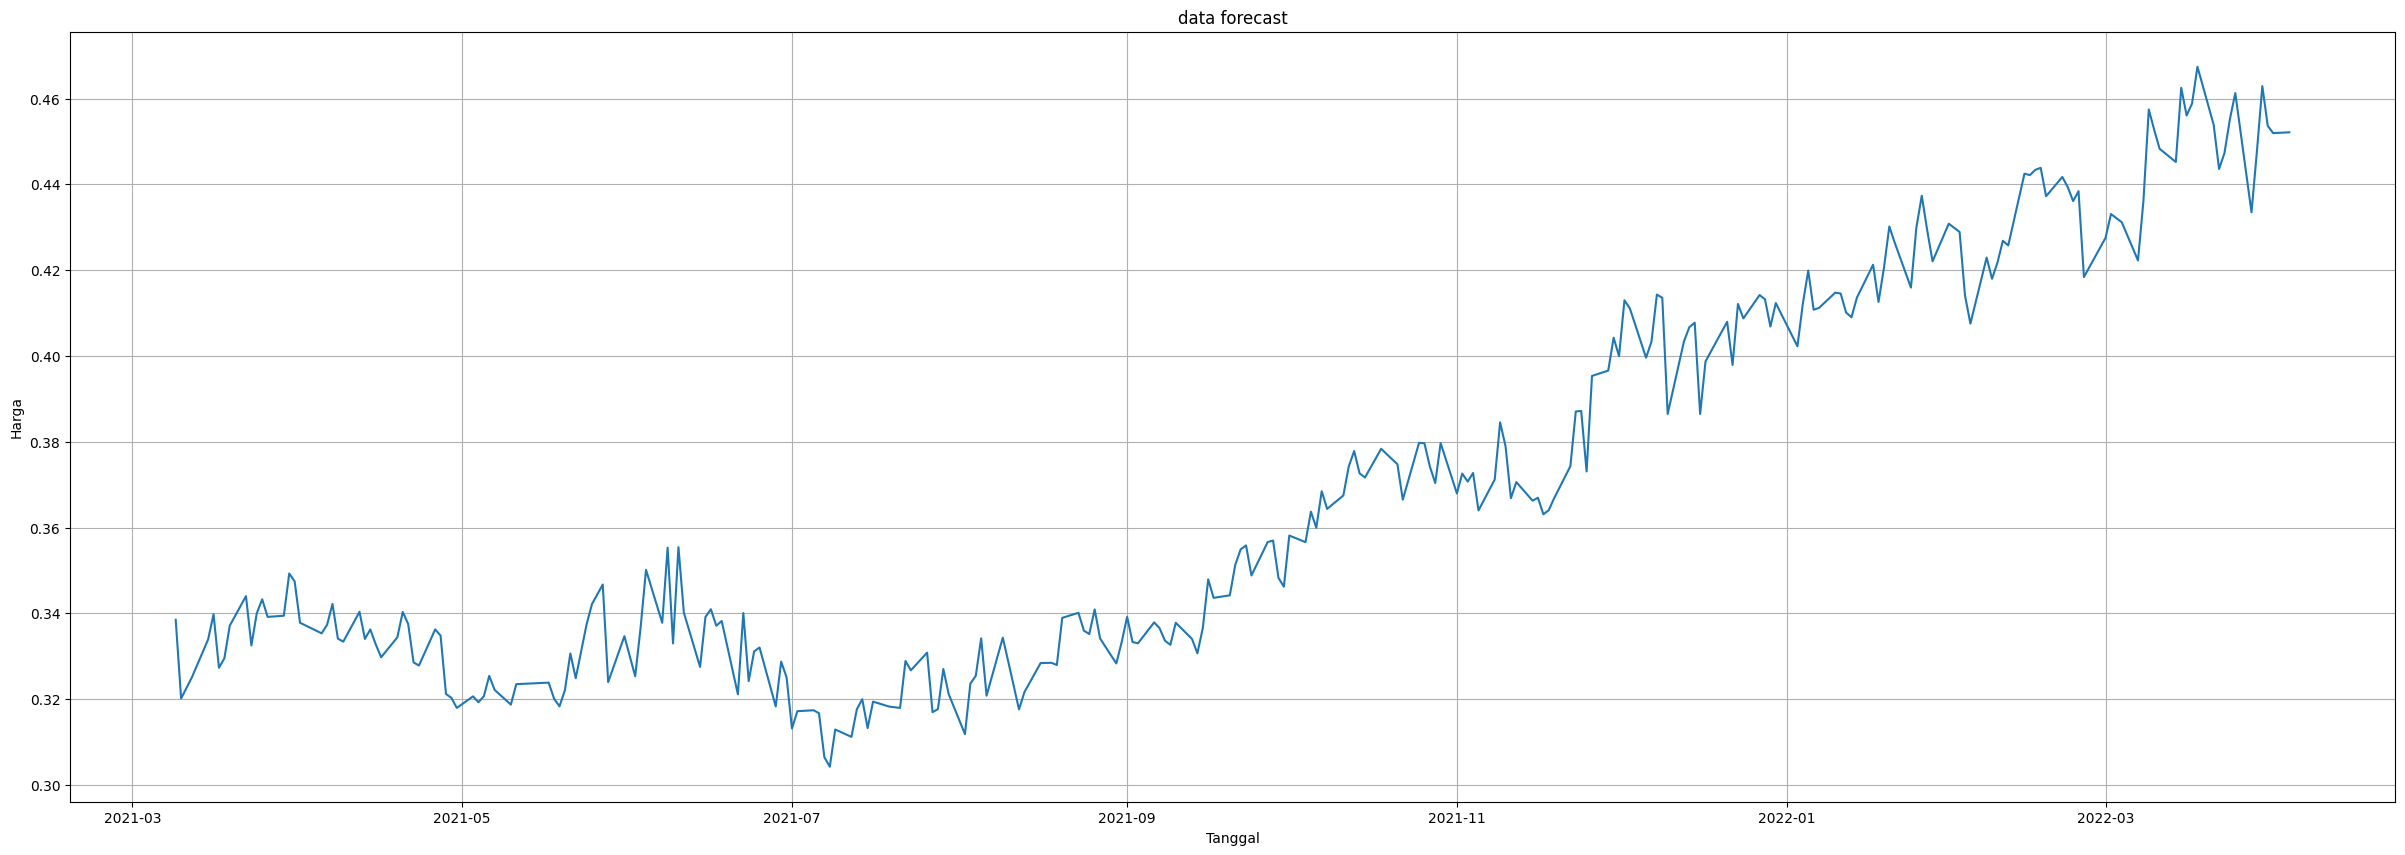

In [174]:

def forecast(model, series_saham, window_size):
  """
    Memprediksi nilai saham berdasarkan parameter model

    Args:
      model         = Model Tensorflow
      series_saham  = Data time series
      window_size   = Ukuran cuplikan

    Returns:
      results = Hasil prediksi
  """
  # Buat dulu list
  forecast = []
  prediction = 0

  # Buat data forecast sebanyak "SPLIT + cuplikan" yang artinya dimulai dari
  # INDEX_SPLIT - CUPLIKAN (DATA KE X - WINDOW_SIZE)
  forecast_series_saham = series_saham[split_time - WINDOW_SIZE:]

  # Loop prediksi tiap cuplikan dari sebesar banyaknya data series saham
  for time in range(len(forecast_series_saham) - WINDOW_SIZE):

    window_input = forecast_series_saham[time : time + WINDOW_SIZE][np.newaxis]/ 10000 # ............ Input Cuplikan
    prediction = model.predict(window_input, verbose=0) # ........................................... Prediksi
    forecast.append(prediction) # ................................................................... Menyimpan hasil prediksi

  results = np.array(forecast).squeeze() # Ubah ke array dan hapus dimensi tunggal
  return results

# Jalankan prediksi
results = forecast(model, series_saham, WINDOW_SIZE)
# # Plot hasil prediksi vs data validasi

plot_series(timeSaham_valid, seriesSaham_valid, title="data aktual")
plot_series(timeSaham_valid, results, title="data forecast")

In [176]:
# Simpan Parameter AI
model_save_path = '/content/prediktor_saham.h5'

# Save model
model.save(model_save_path)

print(f"Model disimpan di : {model_save_path}")

Model disimpan di : /content/prediktor_saham.h5
